In [4]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema

# Plots

The notebook collects the plots used in the paper

## KS Bands and DOS

In [129]:
bands_file = 'QE_bands/bands.save/data-file-schema.xml'
dos_file = 'NSCF/bnds_16-kpoints_8.save/data-file-schema.xml'
dosKpump_file = 'NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml'

hsp = U.high_sym_fcc

In [130]:
bands = U.BandStructure.from_Pw(bands_file,hsp,set_gap=1.42)

Apply a scissor of 0.5446695074337246 eV


In [131]:
hs_positions = bands.get_high_sym_positions()
print(hs_positions)

kspan = 0.05 #in unit of 2pi/alat
k0 = 0.8660254037844385

(['G', 'G', 'X', 'L', 'K'], [0.8660254037844385, 4.28023896615753, 1.8660254037844377, 0.0, 2.866025403784435])


In [132]:
dos = U.Dos.from_Pw(dos_file,set_gap=1.42,label='dos',eta=0.05,minVal=-4,maxVal=4)
dos.append_fromPw(dosKpump_file,set_gap=1.42,label='dosKpump',eta=0.01,minVal=-4,maxVal=4)

Apply a scissor of 0.5446694952016056 eV
Apply a scissor of 0.5456147497318283 eV


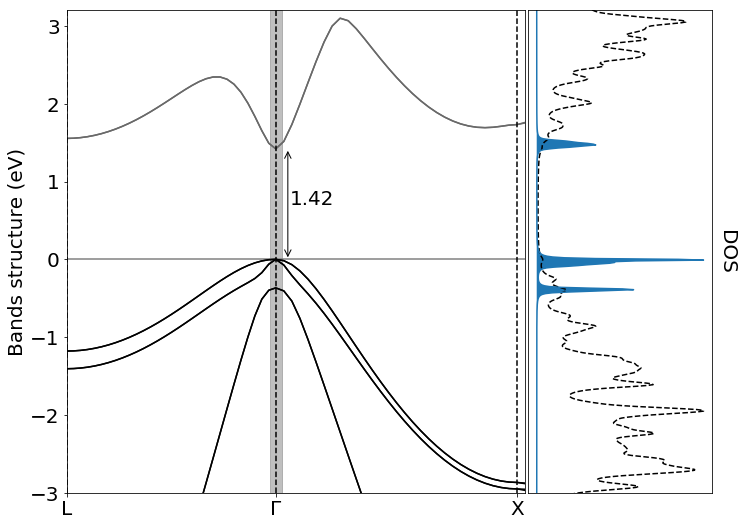

In [133]:
ymax = 3.2
ymin = -3.
label_size = 20

fig = plt.figure(figsize=(10, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# script for the bands
path = bands.get_path()
labels,positions = bands.get_high_sym_positions()
val_bands = [2,3,4,5,6,7]
cond_bands = [8,9]
for ind in val_bands:
    ax0.plot(path,bands.bands[ind],color='black')
for ind in cond_bands:
    ax0.plot(path,bands.bands[ind],color='dimgray')
    
for pos in positions:
    ax0.axvline(pos,color='black',ls='--')
lb = []
for l in labels:
    if l == 'G': lb.append('$\Gamma$')
    else: lb.append(l)
#ax0.arrow(k0+0.1,0.,0.,1.4)
ax0.annotate('', xy=(k0+0.05, 0), xytext=(k0+0.05, 1.42), arrowprops=dict(arrowstyle='<->'),size=16)
ax0.text(k0+0.06,0.7,'1.42',size=label_size)
ax0.set_xticklabels(lb,size=label_size)
ax0.set_xticks(positions)
ax0.set_ylim(ymin,ymax)
ax0.set_xlim(0,1.9)
ax0.set_ylabel('Bands structure (eV)',size=label_size)
ax0.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
ax0.hlines(0.,0.,2,linestyles='-',color='gray')
ax0.tick_params(axis='both', which='major', labelsize=label_size)

# script for the dos
scale = max(dos.dos[0][1])
ax1.plot(dos.dos[0][1]/scale,dos.dos[0][0],linestyle='--',color='black')
scale = max(dos.dos[1][1])
ax1.plot(dos.dos[1][1]/scale,dos.dos[1][0],color='tab:blue')
ax1.fill_between(dos.dos[1][1]/scale,dos.dos[1][0], 0)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(ymin,ymax)
ax1.set_ylabel('DOS',size=label_size,rotation=270)
ax1.yaxis.set_label_coords(1.03,0.5)

plt.tight_layout(pad=-0.4)

#plt.savefig(fname='bands_dos_LGX.eps',format='eps',bbox_inches = "tight")
plt.show()

## Absorption and JDOS

We read the experimental n and k parameters and build the experimental $\epsilon_2$

In [32]:
from pandas_ods_reader import read_ods

In [33]:
abs_data = read_ods('GaAs_nk.ods', 1, columns=['energy', 'n', 'k'])

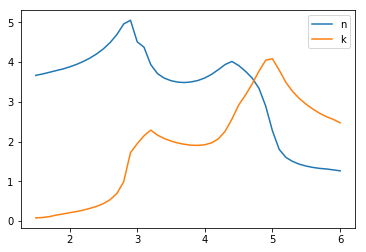

In [34]:
plt.plot(abs_data.energy,abs_data.n,label='n')
plt.plot(abs_data.energy,abs_data.k,label='k')
plt.legend()

In [35]:
energy_exp = np.array(abs_data.energy)
eps2_exp = 2.*np.array(abs_data.n)*np.array(abs_data.k)**2

In [36]:
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml


In [37]:
weights_100 = r_100.weights

In [38]:
transitions_100 = r_100.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])

Apply a scissor of 0.5456147497318283 eV


In [39]:
dos = U.Dos()
dos.append_fromPwData(transitions_100,weights_100,minVal=1,maxVal=3,eta=0.004,label='JDOS')

In [40]:
dos.append(energies=np.array([1.5]),norm=8,eta=0.04,minVal=1,maxVal=3,label='Field',broad_kind=U.gaussian)

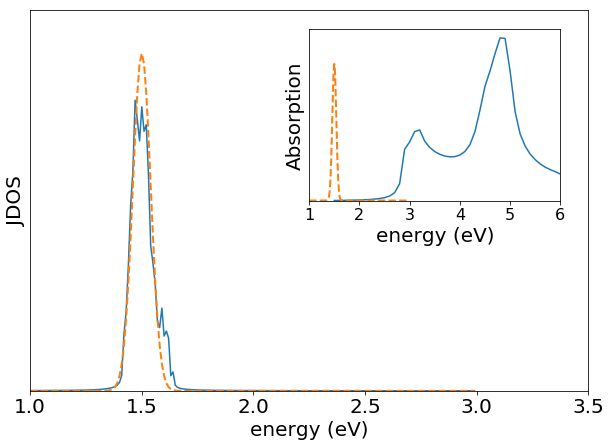

In [41]:
ymax = 90
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(dos.dos[0][0],dos.dos[0][1], label='JDOS')
ax1.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('JDOS',size=label_size)
ax1.set_xlim(1,3.5)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(energy_exp,eps2_exp)
ax2.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax2.set_ylabel('Absorption',size=label_size)
ax2.set_yticks([])
ax2.set_xlabel('energy (eV)',size=label_size)
ax2.set_ylim(0,100)
ax2.set_xlim(1,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_cv.eps',format='eps',bbox_inches = "tight")
plt.show()

### IP absorption

We plot the IP absorption spectrum in the main frame of the figure. To build the absorption we compute the
weight of each transition using the square of the matrix element of the dipole

In [42]:
dipoles = U.get_variable_from_db('RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000/ndb.dipoles','DIP_iR')
dipoles = dipoles[0:100]

In [43]:
def get_dip_squared(dipoles,kpoint,band1,band2,component):
    value = dipoles[kpoint][band1][band2][component]
    return value[0]**2+value[1]**2

In [44]:
def eval_dipole_weights(dipoles,in_list,fin_list,component=2):
    """
    Compute the weight associated the the transitions

    Args:
        dipoles (:py:class:`ndarray`) : array with the dipoles elements
        in_list (list) : indexes of the bands used as starting points of the transitions
        fin_list (list) : indexes of the bands used as final points of the transitions

    Returns:
        transitions (list) : list with the transition energies for each possible couple
        of (distinct) in and out bands
    """
    dip_weights = []
    for k in range(len(dipoles)):
        weights = []
        for v in in_list:
            for c in fin_list:
                if c > v:
                    weights.append(get_dip_squared(dipoles,k,v,c,component))
        dip_weights.append(weights)
    return np.array(dip_weights)

In [45]:
dip_weights = eval_dipole_weights(dipoles,in_list=[0,1,2,3],fin_list=[4,5])

In [59]:
dos = U.Dos()
dos.append(transitions_100.flatten(),dip_weights.flatten(),minVal=1,maxVal=3,eta=0.004,label='Abs')
dos.append(energies=np.array([1.5]),norm=8,eta=0.04,minVal=1,maxVal=3,label='Field',broad_kind=U.gaussian)

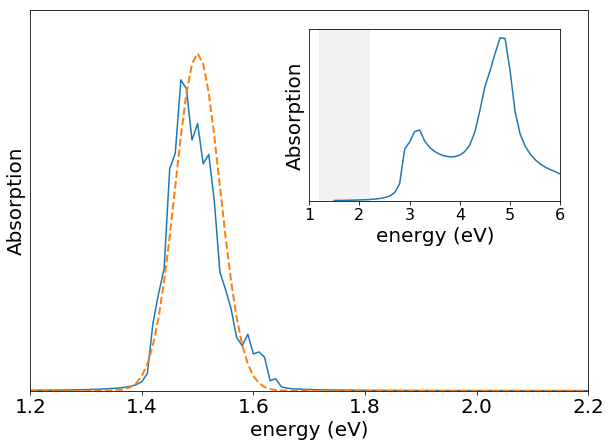

In [60]:
ymax = 90
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(dos.dos[0][0],2.6e-4*dos.dos[0][1], label='Abs')
ax1.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('Absorption',size=label_size)
ax1.set_xlim(1.2,2.2)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(energy_exp,eps2_exp)
#ax2.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax2.axvspan(1.2, 2.2, alpha=0.2, color='silver')
ax2.set_ylabel('Absorption',size=label_size)
ax2.set_yticks([])
ax2.set_xlabel('energy (eV)',size=label_size)
ax2.set_ylim(0,100)
ax2.set_xlim(1,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#ax1.annotate("", xy=(1.6, 50), xytext=(1.8, 50),arrowprops=dict(arrowstyle="->"))

#plt.savefig(fname='abs_cv.eps',format='eps',bbox_inches = "tight")
plt.show()

### IP Absorption using yambo computation on the whole BZ

In [64]:
data_20 = P.YamboParser.from_path('ABS_k20/ip_abs')

In [65]:
epsBZ = data_20['eps_q1_ip']
energyBZ = epsBZ['col0']
epsBZ_im = epsBZ['col1']
epsBZ_re = epsBZ['col2']

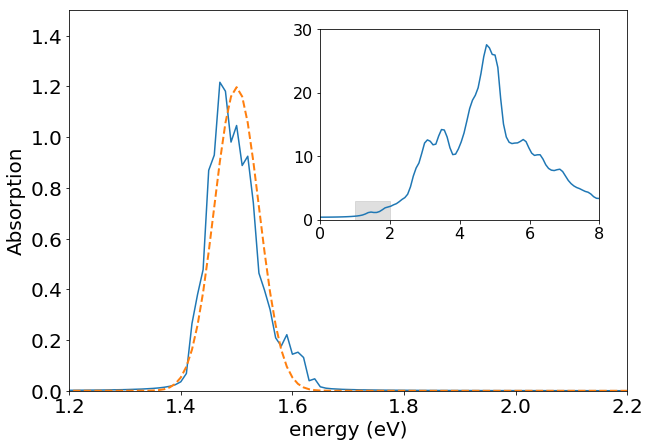

In [68]:
ymax = 1.5
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(dos.dos[0][0],4.3e-6*dos.dos[0][1], label='Abs')
ax1.plot(dos.dos[1][0],1.5e-2*dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('Absorption',size=label_size)
ax1.set_xlim(1.2,2.2)
ax1.set_ylim(0,ymax)
#ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.45,0.45,0.5,0.5])
ax2.set_axes_locator(ip)
ax2.plot(energyBZ,epsBZ_im)
#ax2.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax2.axvspan(1., 2.,ymin=0,ymax=0.1, alpha=0.5, color='silver')
#ax2.set_ylabel('Absorption',size=label_size)
#ax2.set_yticks([])
#ax2.set_xlabel('energy (eV)',size=label_size)
ax2.set_ylim(0,30)
ax2.set_xlim(0,8)
ax2.tick_params(axis='both', which='major', labelsize=16)

#ax1.annotate("", xy=(1.6, 1), xytext=(1.8, 1),arrowprops=dict(arrowstyle="<->"))

#plt.savefig(fname='abs_cv.eps',format='eps',bbox_inches = "tight")
plt.show()

## JDOS c-c' and spin splitting

In [69]:
r_50 = P.PwParser('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml')
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml


In [70]:
transitions_50 = 1e3*r_50.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_100 = 1e3*r_100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


In [71]:
weights_50 = r_50.weights
weights_100 = r_100.weights

In [72]:
jdos = U.Dos()
jdos.append_fromPwData(transitions_50,weights_50,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=50')
jdos.append_fromPwData(transitions_100,weights_100,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=100')

In [73]:
hsp = U.high_sym_fcc
bands = U.BandStructure.from_Pw('QE_bands/bands_G-K.save/data-file-schema.xml',hsp,set_gap=1.42)

Apply a scissor of 0.5446694973756367 eV


In [74]:
path = bands.get_path()
b = bands.get_bands()
spin_splitting = 1e3*(b[9]-b[8]) # in meV

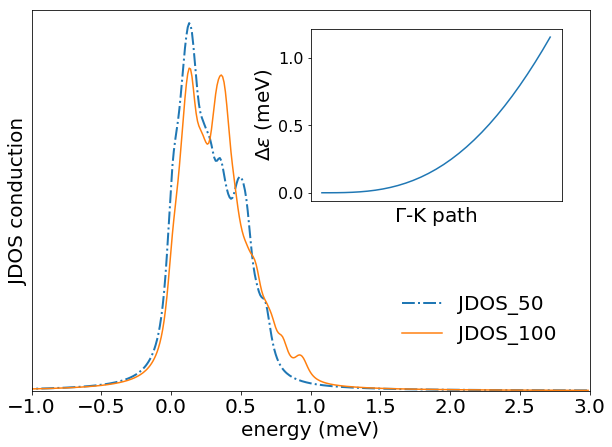

In [75]:
ymax = 2
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(jdos.dos[0][0],jdos.dos[0][1], label='JDOS_50',linestyle='-.',linewidth=2)
ax1.plot(jdos.dos[1][0],jdos.dos[1][1], label='JDOS_100')
ax1.set_xlabel('energy (meV)',size=label_size)
ax1.set_ylabel('JDOS conduction',size=label_size)
ax1.set_xlim(-1,3)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=(0.65,0.1),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(path,spin_splitting)
ax2.set_ylabel('$\Delta\epsilon$ (meV)',size=label_size)
ax2.set_xticks([])
ax2.set_xlabel('$\Gamma$-K path',size=label_size)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_ccp.eps',format='eps',bbox_inches = "tight")
plt.show()

## JDOS c-c' and spin splitting (with band plot)

In [76]:
r100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')
r200 = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml')
r200_v1 = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save_v1/data-file-schema.xml')

t100 = 1e3*r100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
t200 = 1e3*r200.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
t200_v1 = 1e3*r200_v1.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

w100 = r100.weights
w200 = r200.weights
w200_v1 = r200_v1.weights

merge = w100.tolist() + w200.tolist() + w200_v1.tolist()
w500 = np.array(merge)/3

merge = t100.tolist() + t200.tolist() + t200_v1.tolist()
t500 = np.array(merge)

Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save_v1/data-file-schema.xml
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


In [77]:
jdos = U.Dos()
jdos.append_fromPwData(t100,w100,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=100')
jdos.append_fromPwData(t200,w200,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=200')
jdos.append_fromPwData(t200_v1,w200_v1,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=200_v1')
jdos.append_fromPwData(t500,w500,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=500')

In [78]:
hsp = U.high_sym_fcc
bands = U.BandStructure.from_Pw('QE_bands/bands_K-G-K.save/data-file-schema.xml',hsp,set_gap=1.42)

Apply a scissor of 0.5446695036141547 eV


In [79]:
gamma_pos = bands.get_high_sym_positions()[1][0]
gamma_pos

0.035355339059327376

In [80]:
path = bands.get_path()
b = bands.get_bands()
b8 = b[8]-min(b[8])
b9_scaled = b[9]*(1+0.3*(path-gamma_pos))-min(b[9])

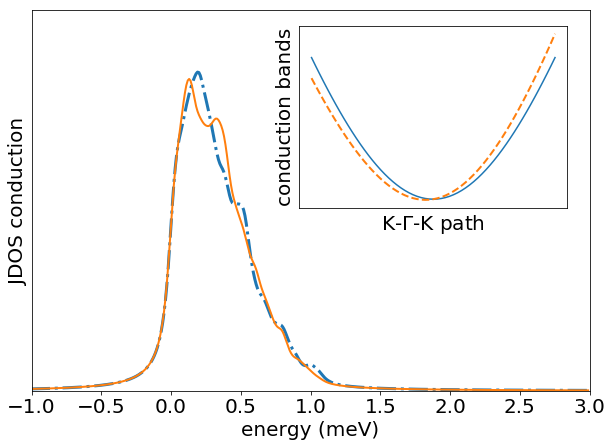

In [83]:
ymax = 2
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(jdos.dos[1][0],jdos.dos[1][1], label='JDOS_200',linestyle='-.',linewidth=3)
ax1.plot(jdos.dos[3][0],jdos.dos[3][1], label='JDOS_500',linewidth=2)
ax1.set_xlabel('energy (meV)',size=label_size)
ax1.set_ylabel('JDOS conduction',size=label_size)
ax1.set_xlim(-1,3)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)
#ax1.legend(loc=(0.65,0.1),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.48,0.48,0.48,0.48])
ax2.set_axes_locator(ip)
ax2.plot(path,b8)
ax2.plot(path,b9_scaled,linestyle='--',linewidth=2)
ax2.set_yticks([])
ax2.set_ylabel('conduction bands',size=label_size)
ax2.set_xticks([])
ax2.set_xlabel('K-$\Gamma$-K path',size=label_size)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_ccp.eps',format='eps',bbox_inches = "tight")
plt.show()

Compute the weighted average

In [88]:
ind = 3
eng = jdos.dos[ind][0]
dd = jdos.dos[ind][1]
wavg = 0.
for e,d in zip(eng,dd):
    wavg += e*d
wavg = wavg/sum(dd)
print(wavg)
U.Planck_ev_ps/(1e-3*wavg)

0.3136941410261379


13.183758174353036

In [90]:
U.Planck_ev_ps/(1e-3*0.313)

13.212995833865813

## Spin polarization

Path of the data of the degree of spin polarization in various cases 

In [250]:
path1k_maxfreq = 'RT_1k-maxfreq/FixSymm/dephase_0.002-freq_1.533-int_1000.0-simTime_10000/'
path1k_medfreq = 'RT_1k-medfreq/FixSymm/dephase_0.002-freq_1.533-int_1000.0-simTime_10000/'

# path the 20 ps simulations
path100 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000-thrs_1e-6/'
path200 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path200_v1 = 'RT_k200_v1/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path200_w400 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000-width_400/'
path200_w1000 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000-width_1000/'
path200_kspan_ext = 'RT_k200_kspan0.07/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'

In [251]:
#data50_longpule = P.YamboParser.from_path(path50_longpulse)
data1k_maxfreq = P.YamboParser.from_path(path1k_maxfreq)
#data1k_medfreq = P.YamboParser.from_path(path1k_medfreq)

# data for the 20 ps simulations
data100 = P.YamboParser.from_path(path100)
data200 = P.YamboParser.from_path(path200)
data200_v1 = P.YamboParser.from_path(path200_v1)
data200_w400 = P.YamboParser.from_path(path200_w400)
data200_w1000 = P.YamboParser.from_path(path200_w1000)

data200_kspan_ext = P.YamboParser.from_path(path200_kspan_ext)


In [252]:
carr100 = data100['carriers']
carr200 = data200['carriers']
carr200_v1 = data200_v1['carriers']

field200 = data200['external_field']
field200_w400 = data200_w400['external_field']
field200_w1000 = data200_w1000['external_field']

spin100 = data100['spin_magnetization']
spin200 = data200['spin_magnetization']
spin200_v1 = data200_v1['spin_magnetization']
spin200_w400 = data200_w400['spin_magnetization']
spin200_w1000 = data200_w1000['spin_magnetization']

spin200_kspan_ext = data200_kspan_ext['spin_magnetization']


spin1k_maxfreq = data1k_maxfreq['spin_magnetization']
#spin1k_medfreq = data1k_medfreq['spin_magnetization']

Extract the degree of spin polarization and build the average on the global 500 points k sampling

In [253]:
time = spin100['time'] # time variables are the same in the sampling
time_ps = 1e-3*time

time_w400 = spin200_w400['time']
time_w400_ps = 1e-3*time_w400

time_w1000 = spin200_w1000['time']
time_w1000_ps = 1e-3*time_w1000

time_kspan_ext = spin200_kspan_ext['time']

ne100 = carr100['dne']
ne200 = carr200['dne']
ne200_v1 = carr200_v1['dne']

pz100 = spin100['Mc_z']
pz200 = spin200['Mc_z']
pz200_v1 = spin200_v1['Mc_z']
pz200_w400 = spin200_w400['Mc_z']
pz200_w1000 = spin200_w1000['Mc_z']

pz200_kspan_ext = spin200_kspan_ext['Mc_z']

mz100 = pz100*ne100
mz200 = pz200*ne200
mz200_v1 = pz200_v1*ne200_v1

ne_tot = 1./500*(100*ne100+200*ne200+200*ne200_v1)
mz_tot = 1./500*(100*mz100+200*mz200+200*mz200_v1)
pz_tot = mz_tot/(ne_tot+1e-10)

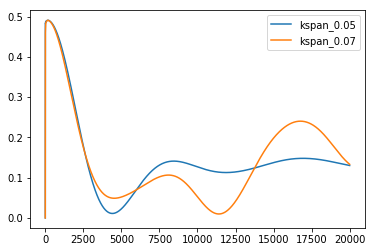

In [254]:
plt.plot(time,pz200,label='kspan_0.05')
plt.plot(time_kspan_ext,pz200_kspan_ext,label='kspan_0.07')
plt.legend()

Add the damping due to the eta factor

In [83]:
eta_cc = 0.05 #meV
eta_ps = eta_cc/(U.Planck_ev_ps*1e3)
print('damping time',1/eta_ps,'ps')
pz_inf = 0.126
pz_deph = (pz_tot-pz_inf)*np.exp(-eta_ps*time_ps)+pz_inf

damping time 82.71335391999999 ps


### Plot of the spin polarization cut at 20 ps with asymptotic value

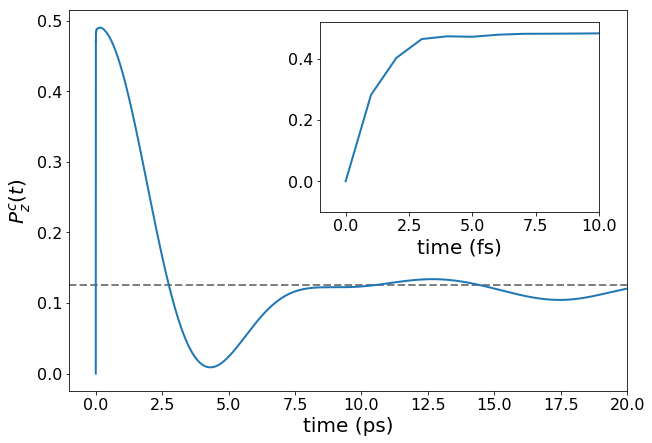

In [84]:
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))
#ax1.plot(time_ps,pz_tot,linewidth=2)
ax1.plot(time_ps,pz_deph,linewidth=2)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('$P_z^c(t)$',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.hlines(0.126,-1,20,linestyle='--',color='gray',linewidth=2)
ax1.set_xlim(-1,20)

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.45,0.47,0.5,0.5])
ax2.set_axes_locator(ip)
#ax2.plot(time,mz_tot)
ax2.plot(time,pz_deph,linewidth=2)
ax2.set_xlabel('time (fs)',size=label_size)
#ax2.set_ylabel('$m_z^c(t)$',size=18)
#ax2.set_ylabel('$P_z^c(t)$',size=18)
#ax2.set_yticks([])
#ax2.set_xlim(-10,400) # for mz
ax2.set_xlim(-1,10) # for pz
ax2.set_ylim(-0.1,0.52)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='pz_inset.eps',format='eps',bbox_inches = "tight")
plt.show()


In the inse twe can report $m_z^c$ or $P_z^c$ in the initial phase of the dynamics

### Plot of the spin polarization comparing different k samplings and insets with carriers and profile of the field

In [28]:
lat_vol = 287.344 #a.u.
lat_vol_ang = lat_vol * 0.529177249
lat_vol_cm = lat_vol_ang *1e-24

#ratio volume between BZ and Kpump
ratio = 0.05**3/(0.25)
ne_norm = ne_tot * ratio / lat_vol_cm
ne_norm[-1]

1.5044631652689902e+16

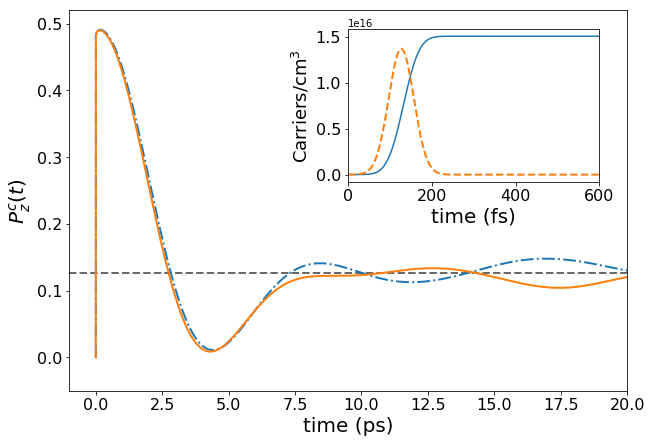

In [31]:
label_size = 20
sim_time = 20

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time_ps,pz200,linestyle='-.',linewidth=2)
ax1.plot(time_ps,pz_deph,linewidth=2)
ax1.hlines(0.126,-1,sim_time,linestyle='--',linewidth=2,color='dimgray')
ax1.set_xlim(-1,sim_time)
ax1.set_ylim(-0.05,0.52)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('$P_z^c(t)$',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.5,0.55,0.45,0.4])
ax2.set_axes_locator(ip)
ax2.plot(time,ne_norm)
#ax2.plot(field200['time'],field200['Intensity']*max(carr_100['dne'])/(max(field_100['Intensity'])),linestyle='--',linewidth=2)
ax2.plot(field200['time'],field200['Intensity']*ne_norm[-1]/550,linestyle='--',linewidth=2)
ax2.set_xlabel('time (fs)',size=label_size)
ax2.set_ylabel('Carriers/cm$^3$',size=18)
#ax2.set_yticks([])
ax2.set_xlim(0,600)
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(fname='pz_carriers.eps',format='eps',bbox_inches = "tight")
plt.show()

### Plot of the spin polarization associated to a single k point

In [105]:
time1 = spin1k_maxfreq['time']*1e-3 # in ps
mz1 = spin1k_maxfreq['Mc_z']

time2 = spin1k_medfreq['time']*1e-3 # in ps
mz2 = spin1k_medfreq['Mc_z']

In [106]:
t_max = time[argrelextrema(-mz1, np.greater)[0]]
t_max

array([6.00000e+00, 9.00000e+00, 2.34072e+03, 6.87720e+03])

In [107]:
6.663-2.305

4.3580000000000005

In [108]:
t_max = time[argrelextrema(mz2, np.greater)[0]]
t_max

array([4.00000e+00, 8.00000e+00, 1.20000e+01, 1.60000e+01, 2.00000e+01,
       1.99000e+02, 7.21312e+03])

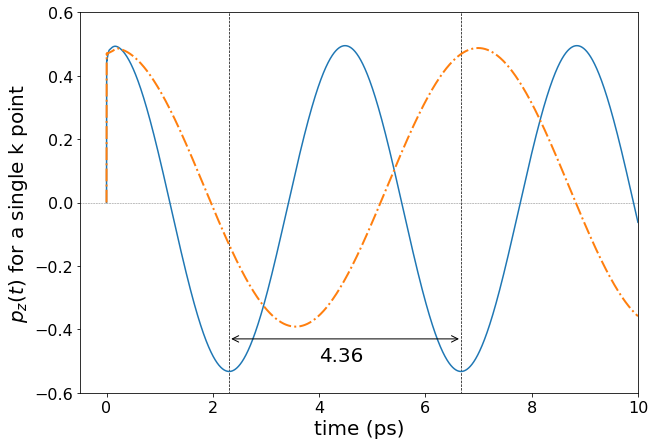

In [109]:
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time1,mz1,label='mz1')
ax1.plot(time2,mz2,label='mz2',linestyle='-.',linewidth=2)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('$p_z(t)$ for a single k point',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.vlines(2.308,-1,1,linestyles='--',linewidth=0.7)
ax1.vlines(6.67,-1,1,linestyles='--',linewidth=0.7)
ax1.hlines(0.,-1,11,linestyles='--',linewidth=0.5,color='gray')
ax1.annotate('', xy=(2.308,-0.43), xytext=(6.67,-0.43), arrowprops=dict(arrowstyle='<->'),size=16)
ax1.text(4,-0.5,'4.36',size=label_size)
ax1.set_ylim(-0.6,0.6)
ax1.set_xlim(-0.5,10)

#plt.savefig(fname='mz_1k.eps',format='eps',bbox_inches = "tight")
plt.show()

and the associated energy (in meV)

In [38]:
U.Planck_ev_ps/4.358*1e3

0.9489829499770538

## Sum of oscillatory functions

In [3]:
r100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')
r200 = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml')
r200_v1 = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save_v1/data-file-schema.xml')
r200_ext = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml')
r1000 = P.PwParser('NSCF/bnds_16-kpoints_1000-sampling_random_close_Gamma.save/data-file-schema.xml')

t100 = 1e3*r100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
t200 = 1e3*r200.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
t200_v1 = 1e3*r200_v1.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
t200_ext = 1e3*r200_ext.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
t1000 = 1e3*r1000.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

w100 = r100.weights
w200 = r200.weights
w200_ext = r200_ext.weights
w200_v1 = r200_v1.weights

merge = w100.tolist() + w200.tolist() + w200_v1.tolist()
w500 = np.array(merge)/3

merge = t100.tolist() + t200.tolist() + t200_v1.tolist()
t500 = np.array(merge)

Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save_v1/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_1000-sampling_random_close_Gamma.save/data-file-schema.xml
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV
Apply a scissor of 0.5456147497318283 eV


In [5]:
sim_time = 100 # in ps
step = 0.01
time = np.arange(0.,sim_time,step)

fsums = {}
for tt in [t200,t500,t1000]:

    fosc = []
    fsum = 0.
    for e in tt:
        nu = e[0]/(U.Planck_ev_ps*1e3)
        fosc.append(np.cos(2*np.pi*nu*time))
        fsum += np.cos(2*np.pi*nu*time)
    fsum /= len(tt)
    fsums[len(tt)] = fsum

In [6]:
t_min = time[argrelextrema(-fsums[500], np.greater)[0]]
t_min
deltas = []
for i in range(len(t_min)-1):
    deltas.append(t_min[i+1]-t_min[i])
deltas

[11.97,
 10.21,
 6.060000000000002,
 3.9099999999999966,
 5.969999999999999,
 5.010000000000005,
 8.889999999999993,
 7.780000000000008,
 4.489999999999995,
 5.320000000000007,
 3.8499999999999943,
 6.359999999999999,
 9.579999999999998]

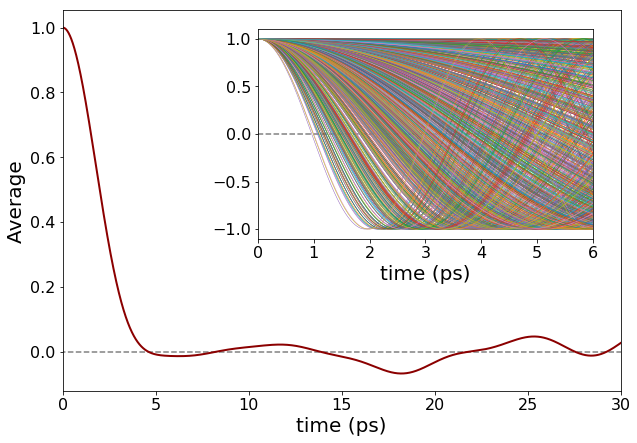

In [7]:
label_size = 20
plot_time = 30

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,fsums[500],linewidth=2,color='darkred')
ax1.hlines(0.,-1,sim_time,linestyle='--',color='gray')
ax1.set_xlim(0,plot_time)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Average',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlim(0,30)
#ax1.legend(loc=(0.25,.7),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.35,0.4,0.6,0.55])
ax2.set_axes_locator(ip)
for f in fosc:
    ax2.plot(time,f,linewidth=0.5)
ax2.hlines(0.,-1,11,linestyle='--',color='gray')
ax2.set_xlabel('time (ps)',size=label_size)
#ax2.set_yticks([])
ax2.set_xlim(0,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='average_oscillations.eps',format='eps',bbox_inches = "tight")
plt.show()

Integral over frequencies using the jdos

In [16]:
jdos = U.Dos()
jdos.append_fromPwData(t500,w500,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=500')
#jdos.append_fromPwData(t200_ext,w200_ext,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=500')
eng = jdos.dos[0][0]
values = jdos.dos[0][1]

In [17]:
from scipy import integrate as I

In [18]:
norm = I.simps(y=values,x=eng)
norm

0.9870700827068594

In [19]:
nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus

In [20]:
tvals = np.linspace(0,50,200)
#tvals

In [21]:
res = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
res = np.array(res)

(0, 10)

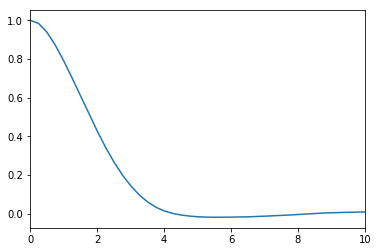

In [22]:
plt.plot(tvals,res)
plt.xlim(0,10)

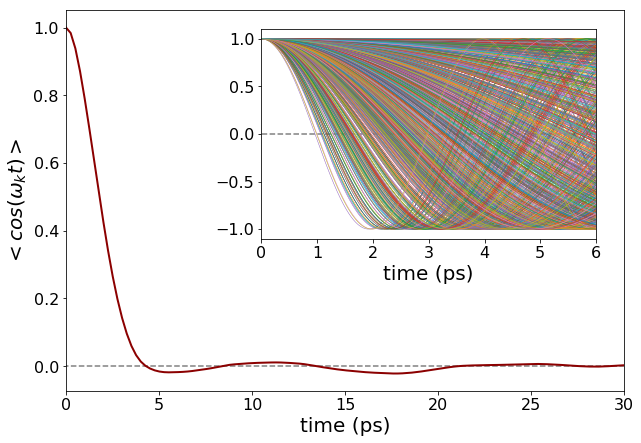

In [26]:
label_size = 20
plot_time = 30

fig, ax1 = plt.subplots(figsize=(10, 7))
#ax1.plot(time,fsums[500],linewidth=2,color='darkred')
ax1.plot(tvals,res,linewidth=2,color='darkred')
ax1.hlines(0.,-1,sim_time,linestyle='--',color='gray')
ax1.set_xlim(0,plot_time)
ax1.set_xlabel('time (ps)',size=label_size)
#ax1.set_ylabel('Average',size=label_size)
ax1.set_ylabel('$<cos(\omega_{k}t)>$',size=label_size)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlim(0,30)
#ax1.legend(loc=(0.25,.7),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.35,0.4,0.6,0.55])
ax2.set_axes_locator(ip)
for f in fosc:
    ax2.plot(time,f,linewidth=0.5)
ax2.hlines(0.,-1,11,linestyle='--',color='gray')
ax2.set_xlabel('time (ps)',size=label_size)
#ax2.set_yticks([])
ax2.set_xlim(0,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='dos_avg_oscillations.eps',format='eps',bbox_inches = "tight")
plt.show()

## Analysis of the dependence on the pulse width

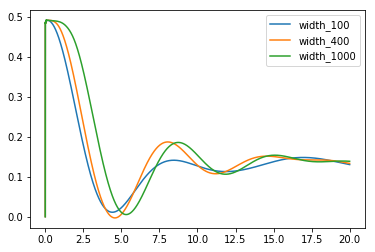

In [89]:
plt.plot(time_ps,pz200,label='width_100')
plt.plot(time_w400_ps,pz200_w400,label='width_400')
plt.plot(time_w1000_ps,pz200_w1000,label='width_1000')
plt.legend()
#plt.show?

(0, 2500)

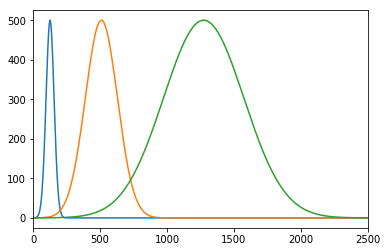

In [95]:
plt.plot(time,field200['Intensity'])
plt.plot(time_w400,field200_w400['Intensity'])
plt.plot(time_w1000,field200_w1000['Intensity'])
plt.xlim(0,2500)

The time behavior can be analyzed by looking at the jdos_cc' in optical active region for each pulse

In [168]:
r = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml')

t_cv = r.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
t_ccp = 1e3*r.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


We need to select only the k points with associated transitions that can be activated by the pump

For example

In [169]:
t_cv[57]

array([1.52357279, 1.5238418 , 1.52294438, 1.52321339, 1.48055305,
       1.48082206, 1.48052921, 1.48079822])

The first four numbers are the transition from the valence bands to the first conduction band,
the others are associated to the transitions from the valence bands to the second conduction band.
We choose to include the k point if the both the two transitions can be activated by the pump

In [170]:
t1 = np.mean(t_cv[1][0:4])
t2 = np.mean(t_cv[1][4:])

In [171]:
inside = epump-5e-3*spread <= t2 <= epump+5e-3*spread

In [172]:
def is_activated(t,epump=1.5,spread=40):
    emin = epump-1e-3*spread
    emax = epump+1e-3*spread
    t1 = np.mean(t[0:4])
    t2 = np.mean(t[4:])
    inside1 = emin <= t1 <= emax
    inside2 = emin <= t2 <= emax
    return np.all([inside1,inside2])

In [213]:
spreads = [80,20,8]

In [214]:
k_activated = {}
for sp in spreads:
    k_activated[sp] = []
    for ind,t in enumerate(t_cv):
        if is_activated(t,spread=sp):
            k_activated[sp].append(ind)

In [215]:
t_activated = {}
for sp in k_activated:
    t_act = []
    for k in k_activated[sp]:
        t_act.append(t_ccp[k][0])
    t_activated[sp] = np.array(t_act)

In [216]:
#t_activated

In [217]:
jdos = U.Dos()
for sp in t_activated:
    jdos.append(t_activated[sp],minVal=-2,maxVal=3,eta=0.05,label=sp)

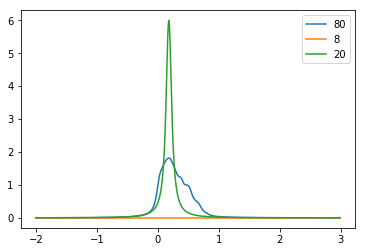

In [218]:
jdos.plot(plt)
plt.legend()

### Analysis of the trace with $\sigma = 1$

In [48]:
path100 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000/'
path100_width100 = 'RT_k100_rhocheck/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-width_100/'

In [49]:
data100_old = P.YamboParser.from_path(path100)
data100_width100 = P.YamboParser.from_path(path100_width100)

In [50]:
spin100_old = data100_old['spin_magnetization']

spin100_width100 = data100_width100['spin_magnetization']
orb_width100 = data100_width100['orbt_magnetization']

In [51]:
time100_old = spin100_old['time']
pz100_old = spin100_old['Mc_z']

time100_width100 = spin100_width100['time']
pz100_width100 = spin100_width100['Mc_z']

rho100_width100 = orb_width100['col6']

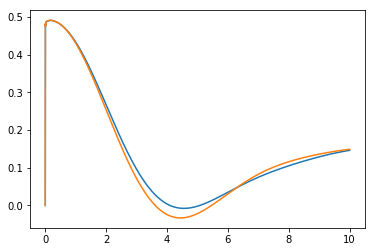

In [52]:
plt.plot(time100_old*1e-3,pz100_old)
plt.plot(time100_width100*1e-3,pz100_width100)

(0.0, 1)

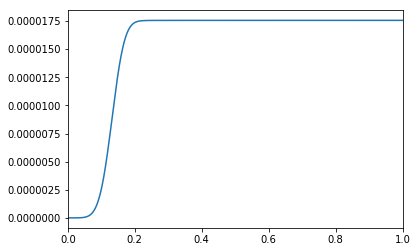

In [47]:
plt.plot(time100_width100*1e-3,rho100_width100)
plt.xlim(0.,1)

In [35]:
orb_width100

{'col0': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.998e+03, 9.999e+03,
        1.000e+04]),
 'col1': array([ 0.00000000e+00, -9.96026750e-13, -4.06024780e-12, ...,
        -1.75546770e-05, -1.75547723e-05, -1.75548661e-05]),
 'col2': array([ 0.00000000e+00, -9.96026750e-13, -4.06024780e-12, ...,
        -1.75546770e-05, -1.75547723e-05, -1.75548661e-05]),
 'col3': array([ 0.00000000e+00, -9.96026750e-13, -4.06024780e-12, ...,
        -1.75546770e-05, -1.75547723e-05, -1.75548661e-05]),
 'col4': array([0.00000000e+00, 9.96130150e-13, 4.06060700e-12, ...,
        1.75635747e-05, 1.75635754e-05, 1.75635762e-05]),
 'col5': array([0.00000000e+00, 9.96130150e-13, 4.06060700e-12, ...,
        1.75635747e-05, 1.75635754e-05, 1.75635762e-05]),
 'col6': array([0.00000000e+00, 9.96130150e-13, 4.06060700e-12, ...,
        1.75635747e-05, 1.75635754e-05, 1.75635762e-05])}

## Analysis single k (with -nosym option)

In [20]:
path1k_maxfreq = 'RT_1k-maxfreq/FixSymm/dephase_0.002-freq_1.533-int_1000.0-simTime_10000/'
path1k_maxfreq_kg = 'RT_1k-maxfreq-KeepGrid/dephase_0.002-freq_1.533-int_1000.0-simTime_10000/'

In [21]:
data1k_maxfreq = P.YamboParser.from_path(path1k_maxfreq)
data1k_maxfreq_kg = P.YamboParser.from_path(path1k_maxfreq_kg)

In [23]:
carr = data1k_maxfreq['carriers']
spin = data1k_maxfreq['spin_magnetization']

carr_kg = data1k_maxfreq_kg['carriers']
spin_kg = data1k_maxfreq_kg['spin_magnetization']

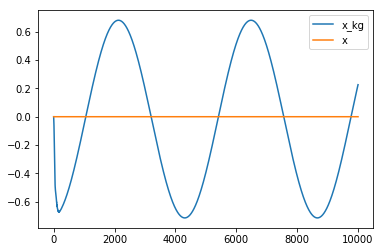

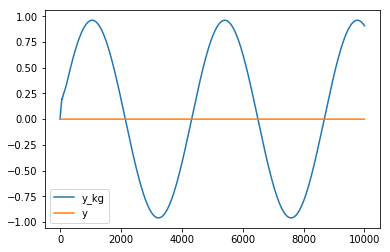

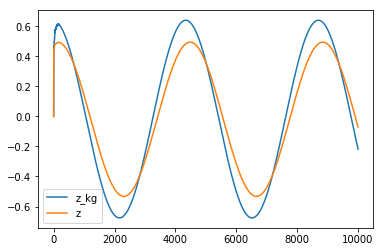

In [26]:
time = spin['time']
time_kg = spin_kg['time']

plt.plot(time_kg,spin_kg['Mc_x'],label='x_kg')
plt.plot(time,spin['Mc_x'],label='x')
plt.legend()
plt.show()

plt.plot(time_kg,spin_kg['Mc_y'],label='y_kg')
plt.plot(time,spin['Mc_y'],label='y')
plt.legend()
plt.show()

plt.plot(time_kg,spin_kg['Mc_z'],label='z_kg')
plt.plot(time,spin['Mc_z'],label='z')
plt.legend()
plt.show()

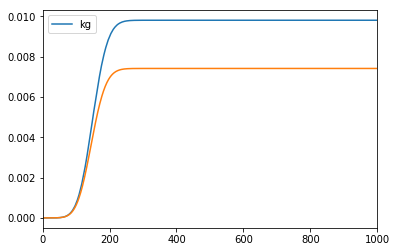

In [28]:
plt.plot(time_kg,carr_kg['dne'],label='kg')
plt.plot(time,carr['dne'],label='')
plt.legend()
plt.xlim(0,1000)
plt.show()


In [46]:
pol = data1k_maxfreq['polarization']

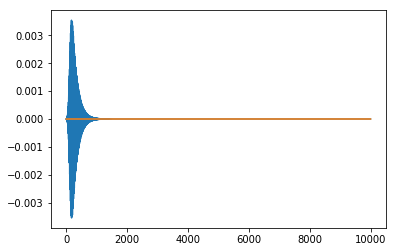

In [47]:
plt.plot(time,pol['Pol_x'])
plt.plot(time,pol['Pol_z'])
#plt.xlim(0,4000)

In [48]:
pol = data1k_maxfreq_kg['polarization']

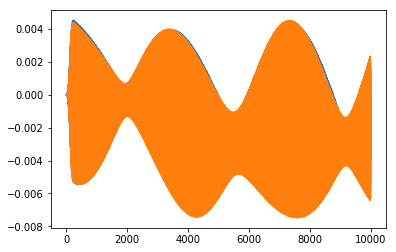

In [49]:
plt.plot(time,pol['Pol_x'])
plt.plot(time,pol['Pol_z'])
#plt.xlim(0,4000)